# Developing a model for heart disease prediction using PyCaret

Author: Jason Bentley  
Date: June 2020  

**Background**

In a developed professional data science environment, you might have access to AWS, GCP, Azure or other platforms or software with tools to perform experiment set-up, tracking and logging. But what if you just want to get a pilot up and running fast or you are doing a research project? This is where PyCaret (https://pycaret.org/) shines with the ability to do experimentation quickly and systematically!

What is PyCaret? Well its creators describe it as an "…open source, low-code machine learning library in Python that allows you to go from preparing your data to deploying your model within seconds in your choice of notebook environment." Anything that lets you spend more time on content and maximizing impact has got to be good, right?

In the following example we will develop, evaluate and inspect a model for predicting heart disease using PyCaret. As this is my first experience with PyCaret I will also provide some summary thoughts and first impressions at the end. As always in any example application involving health, the associations, inferences and commentary in no way constitute medical advice.

In [1]:
# Data management
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Cohort tables
from tableone import TableOne

# PyCaret for classification
from pycaret.classification import *

### The data and EDA

In [2]:
# original file (processed.cleveland.data) from https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/
# dataset has some ? values which are unknowns. Column names from https://archive.ics.uci.edu/ml/datasets/heart+Disease
# load the data - we have 13 features and 1 target, and 303 patients in our dataset
file_cols = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang',
             'oldpeak', 'slope', 'ca', 'thal', 'num']

hd_df = pd.read_csv("processed.cleveland.data",
                    delimiter= ',',
                    header=None,
                    names=file_cols,
                    na_values=['?'])

hd_df.shape

(303, 14)

In [3]:
# quick look
hd_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


For our exploratory data analysis, the features available are:

1. age: patient age in years
2. sex: patient sex, 0 = Female, 1 = Male
3. cp: chest pain type, 1 = typical angina, 2 = atypical angina, 3 = non anginal pain, 4 = asymptomatic
4. trestbps: resting blood pressure in mmHg
5. chol: serum cholesterol in mg/dl
6. fbs: fasting blood sugar > 120 mg/dl, 0 = No, 1 = Yes
7. restecg: resting electrocardiographic results, 0 = normal, 1 = ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), 2 = probable or definite left ventricular hypertrophy by Estes' criteria
8. thalach: maximum heart rate achieved in beats per minute
9. exang: exercise induced angina, 0 = No, 1 = Yes
10. oldpeak: ST depression induced by exercise relative to rest, the higher the value the greater the abnormality in the patient electrocardiogram
11. slope: the slope of the peak exercise ST segment, 1 = upsloping, 2 = flat, 3 = downsloping
12. ca: count of the number of major vessels colored by flourosopy
13. thal: measured blood flow to the heart as a result of a thallium stress test, 3 = normal, 6 = fixed defect, 7 = reversable defect

First we create a summary table as appropriate for these features and for continuous features generate additional visualizations to further help our understanding.

In [4]:
# lets re-label and re-name just to make our understanding a little easier

# specific
d_sex = {0: 'female', 1: 'male'}
d_cp = {1: 'typical_angina', 2: 'atypical_angina', 3: 'non_anginal_pain', 4: 'asymptomatic'}
d_restecg = {0: 'normal', 1: 'ST_T_abnormality', 2: 'LV_hypertrophy'}
d_slope = {1: 'upsloping', 2: 'flat', 3: 'downsloping'}
d_thal = {3: 'normal', 6: 'fixed_defect', 7: 'reversable_defect'}

# generic
d_no_yes = {0: 'no', 1: 'yes'}

# apply mapping
hd_df['sex'].replace(d_sex, inplace=True)
hd_df['cp'].replace(d_cp, inplace=True)
hd_df['restecg'].replace(d_restecg, inplace=True)
hd_df['slope'].replace(d_slope, inplace=True)
hd_df['thal'].replace(d_thal, inplace=True)
hd_df['fbs'].replace(d_no_yes, inplace=True)
hd_df['exang'].replace(d_no_yes, inplace=True)

# rename features to also be a bit easier for direct interpretation
# bp = blood pressure, ecg = electrocardiograph, hr = heart rate, bf = blood flow
d_cols = {
'cp': 'chest_pain',
'trestbps': 'resting_bp',
'chol': 'serum_cholesterol',
'fbs': 'high_fasting_blood_sugar',
'restecg': 'resting_ecg',
'thalach': 'maximum_hr',
'exang': 'exercise_induced_angina',
'oldpeak': 'ST_depression_exercise_vs_rest',
'slope': 'peak_exercise_ST_segment_slope',
'ca': 'num_affected_major_vessels',
'thal': 'thallium_stress_test_bf'
}

# rename selected columns
hd_df.rename(columns=d_cols, inplace=True)

hd_df.head()

,age,sex,chest_pain,resting_bp,serum_cholesterol,high_fasting_blood_sugar,resting_ecg,maximum_hr,exercise_induced_angina,ST_depression_exercise_vs_rest,peak_exercise_ST_segment_slope,num_affected_major_vessels,thallium_stress_test_bf,num
0,63.0,male,typical_angina,145.0,233.0,yes,LV_hypertrophy,150.0,no,2.3,downsloping,0.0,fixed_defect,0
1,67.0,male,asymptomatic,160.0,286.0,no,LV_hypertrophy,108.0,yes,1.5,flat,3.0,normal,2
2,67.0,male,asymptomatic,120.0,229.0,no,LV_hypertrophy,129.0,yes,2.6,flat,2.0,reversable_defect,1
3,37.0,male,non_anginal_pain,130.0,250.0,no,normal,187.0,no,3.5,downsloping,0.0,normal,0
4,41.0,female,atypical_angina,130.0,204.0,no,LV_hypertrophy,172.0,no,1.4,upsloping,0.0,normal,0


In [5]:
# lets create the target, where the values 1, 2, 3, 4 indicate varying degrees of heart disease
hd_df['num'].value_counts(normalize=True)

0    0.541254
1    0.181518
2    0.118812
3    0.115512
4    0.042904
Name: num, dtype: float64

In [6]:
# Lets create a numeric and labelled target. 46% of the cohort have some form of heart disease. Target reasonably balanced.
hd_df['target'] = np.where(hd_df['num'] > 0, 1, 0)
hd_df['target_c'] = np.where(hd_df['num'] > 0, 'Heart_disease', 'No_heart_disease')
hd_df['target_c'].value_counts(normalize=True)

No_heart_disease    0.541254
Heart_disease       0.458746
Name: target_c, dtype: float64

In [7]:
# Create a standard "cohort" table as a first look, define columns of interest for Table
features = list(hd_df.columns[0:13])
cat_features = ['sex', 'chest_pain', 'high_fasting_blood_sugar', 'resting_ecg', 'exercise_induced_angina',
                'peak_exercise_ST_segment_slope', 'thallium_stress_test_bf', 'num_affected_major_vessels']
nonnormal_features = ['age', 'resting_bp', 'serum_cholesterol', 'maximum_hr', 'ST_depression_exercise_vs_rest']

cohort_table = TableOne(hd_df,
                        columns=features,
                        categorical=cat_features,
                        groupby='target_c',
                        nonnormal=nonnormal_features,
                        overall=False)

#print(cohort_table.tabulate(tablefmt = "fancy_grid"))
print(cohort_table)

                                                                 Grouped by target_c                                          
                                                                             Missing        Heart_disease     No_heart_disease
n                                                                                                     139                  164
age, median [Q1,Q3]                                                                0     58.0 [52.0,62.0]     52.0 [44.8,59.0]
sex, n (%)                                     female                              0            25 (18.0)            72 (43.9)
                                               male                                            114 (82.0)            92 (56.1)
chest_pain, n (%)                              asymptomatic                        0           105 (75.5)            39 (23.8)
                                               atypical_angina                                    9 (6.5)      

Patients with heart disease are more likely to be older, male, have asymptomatic chest pain, higher serum cholesterol, lower maximum heart rate, exercise induced angina, higher ST depression during exercise compared to rest, a flat or downsloping peak exercise ST segment slope, affected major vessels, and a blood flow fixed or reversable defect identified by the thallium stress test.

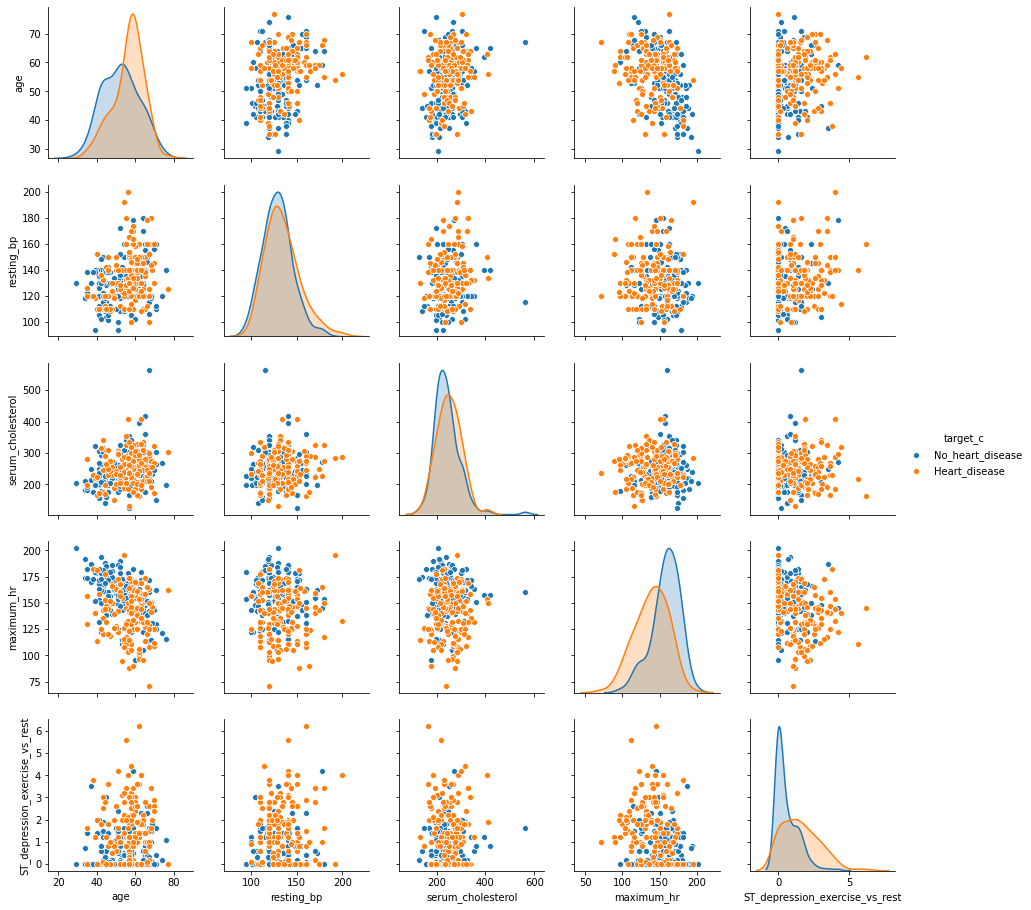

In [8]:
# Now lets look at the continuous variables and the target in a bit more detail
ft_plot = sns.pairplot(hd_df[nonnormal_features + ['target_c']], hue='target_c')
ft_plot.savefig("Fig_2_hd_feature_plot.png")

A few observations that we will need to consider for our pre-preocessing:  
1. A handful of missing values for a continuous (count of vessls identified via fluoroscopy) and a categorical feature (thalium stress test blood flow to the heart) - so we need to decide how we want to handling missing values in our pipeline
2. The resting electrocardiographic result of ST-T abnormality has only 4 cases in the entire cohort - this is a rare level which we could combine with another. It also consitutes a feature with low variance
3. Some potential outliers, with a patient with no heart disease having a serum cholesterol level above 500, and also two patients in the heart disease group with ST depression values > 5 - how do we want to manange outliers in our pipeline

### Experiment set-up

Some of the following steps I will employ may not be in the best interests of developing a model with optimal performance, but the aim here is to highlight how wonderful the set-up for building models can be with PyCaret.

In [9]:
# lets do some re-grouping just to avoid small numbers or categorical features with minimal variance
cp_regroup = {'typical_angina': 'anginal_pain', 'atypical_angina': 'anginal_pain', 'non_anginal_pain': 'non_anginal_pain', 'asymptomatic': 'asymptomatic'}
restecg_regroup = {'normal': 'normal', 'ST_T_abnormality': 'not_normal', 'LV_hypertrophy': 'not_normal'}
slope_regroup = {'upsloping': 'upsloping', 'flat': 'flat_downsloping', 'downsloping': 'flat_downsloping'}
thal_regroup = {'normal': 'normal', 'fixed_defect': 'defect', 'reversable_defect': 'defect'}

# apply re-grouping
hd_df['chest_pain'].replace(cp_regroup, inplace=True)
hd_df['resting_ecg'].replace(restecg_regroup, inplace=True)
hd_df['peak_exercise_ST_segment_slope'].replace(slope_regroup, inplace=True)
hd_df['thallium_stress_test_bf'].replace(thal_regroup, inplace=True)

# check
print(TableOne(hd_df,
               columns=features,
               categorical=cat_features,
               groupby='target_c',
               nonnormal=nonnormal_features,
               overall=False))

                                                                Grouped by target_c                                          
                                                                            Missing        Heart_disease     No_heart_disease
n                                                                                                    139                  164
age, median [Q1,Q3]                                                               0     58.0 [52.0,62.0]     52.0 [44.8,59.0]
sex, n (%)                                     female                             0            25 (18.0)            72 (43.9)
                                               male                                           114 (82.0)            92 (56.1)
chest_pain, n (%)                              anginal_pain                       0            16 (11.5)            57 (34.8)
                                               asymptomatic                                   105 (75.5)            39

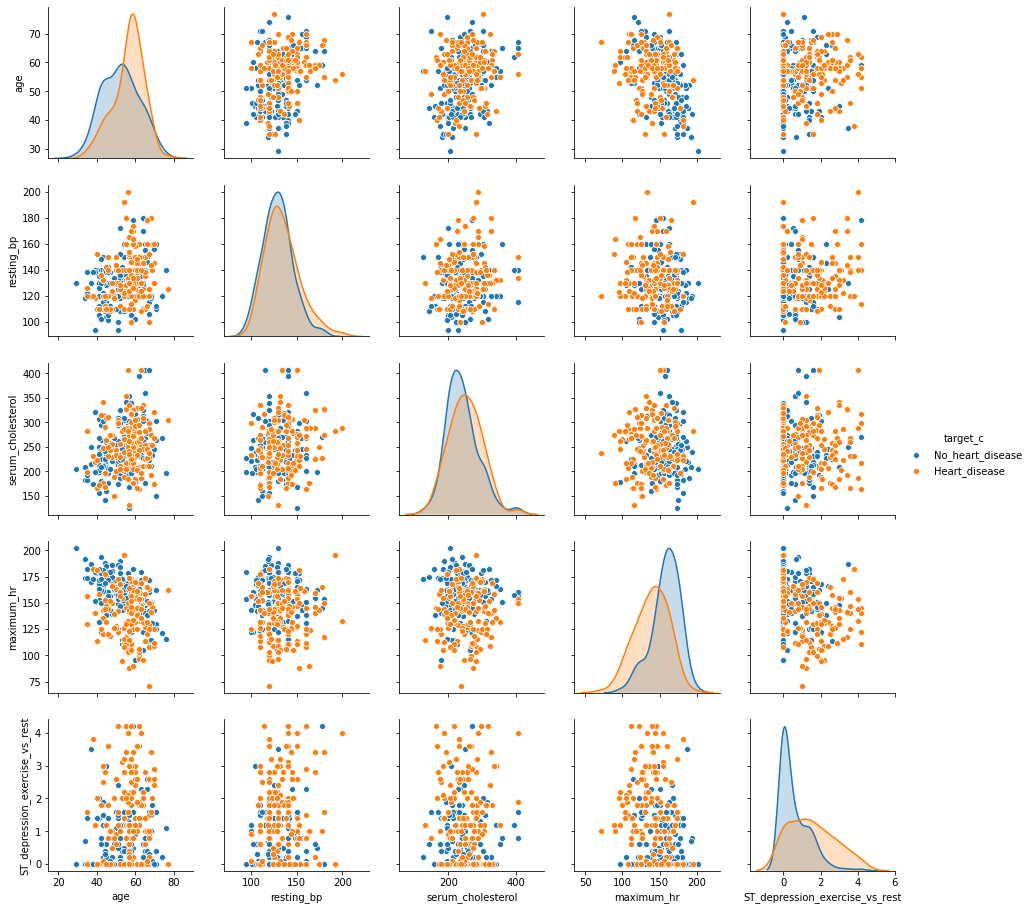

In [10]:
# deal with the few outliers by trimming to 99th percentile
hd_df['serum_cholesterol'].clip(upper=np.percentile(hd_df['serum_cholesterol'], 99), inplace=True)
hd_df['ST_depression_exercise_vs_rest'].clip(upper=np.percentile(hd_df['ST_depression_exercise_vs_rest'], 99), inplace=True)

# check
sns.pairplot(hd_df[nonnormal_features + ['target_c']], hue='target_c')

In [11]:
# couple of key parameters
prop_train = 0.65
num_folds = 10

# experiment set-up
exp1 = setup(hd_df,
             train_size=prop_train,
             target='target',
             session_id=101,
             ignore_features=['num', 'target_c'],
             numeric_imputation = 'median',
             categorical_imputation = 'mode')

 
Setup Succesfully Completed!


,Description,Value
0,session_id,101
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(303, 16)"
4,Missing Values,True
5,Numeric Features,5
6,Categorical Features,10
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [12]:
# Let's have a look at the test dataset created by the set-up (slot 2 here is X_train, 3 is X_test, 4 is y_train, 5 is y_test, 0 is all features, 1 is all y)
X_test = exp1[2]
X_test.describe().T

,count,mean,std,min,25%,50%,75%,max
age,196.0,54.551020,9.045891,34.0,47.0,56.0,61.00,77.00
resting_bp,196.0,131.673469,17.497414,100.0,120.0,130.0,140.00,200.00
serum_cholesterol,196.0,247.470510,50.263420,141.0,211.0,243.5,277.00,406.74
maximum_hr,196.0,150.658163,22.348991,88.0,138.0,155.5,167.25,195.00
ST_depression_exercise_vs_rest,196.0,1.047959,1.136502,0.0,0.0,0.8,1.60,4.20
num_affected_major_vessels,196.0,0.632653,0.915818,0.0,0.0,0.0,1.00,3.00
sex_male,196.0,0.673469,0.470145,0.0,0.0,1.0,1.00,1.00
chest_pain_anginal_pain,196.0,0.244898,0.431128,0.0,0.0,0.0,0.00,1.00
chest_pain_asymptomatic,196.0,0.474490,0.500628,0.0,0.0,0.0,1.00,1.00
chest_pain_non_anginal_pain,196.0,0.280612,0.450449,0.0,0.0,0.0,1.00,1.00


How great was that?! Even better I already feel like I have acheived something with the "Setup Succesfully Completed!". Obviously once you get into situations where you have hundreds or even thousands of predictors controlling every aspect of set-up will be tedious but PyCaret is pretty intuitive at figuring out what seems reasonable based on dtypes at least for continuous versus categorical predictors.

In [13]:
# we can also take a peak at the pipeline
exp1[7]

Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True,
                                      features_todrop=['num', 'target_c'],
                                      ml_usecase='regression',
                                      numerical_features=[], target='target',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='most frequent',
                                numeric_strategy='median',
                                target_variable=None)),
                ('new_levels1',
                 New_Ca...
                ('group', Empty()), ('nonliner', Empty()), ('scaling', Empty()),
                ('P_transform', Empty()), ('pt_target', Empty()),
                ('binn', Empty()), ('rem_outliers', Empty()),
                ('cluster_all', Empty()), ('dummy', Dummify(target='target'

### Identifying a good candidate model

In [14]:
# Compare models will actually contrast 14 different classifiers, but here lets restrict to a few we feel might be 
# good candidates to start with, so lets try a few boosting approaches (gradient, extreme and light), 
# SVMs (linear, radial basis), random forest 
compare_models(blacklist=['lr', 'lda', 'qda', 'et', 'catboost', 'ada', 'ridge', 'dt', 'nb', 'gpc', 'knn', 'mlp'],
               fold=num_folds,
               turbo=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Extreme Gradient Boosting,0.821300,0.891200,0.788900,0.844300,0.801200,0.638900
1,Light Gradient Boosting Machine,0.811300,0.900400,0.788900,0.806600,0.789900,0.618400
2,Random Forest Classifier,0.811100,0.898200,0.733300,0.841300,0.778300,0.615000
3,Gradient Boosting Classifier,0.795800,0.865200,0.744400,0.812500,0.768600,0.586500
4,SVM - Linear Kernel,0.576300,0.000000,0.922200,0.538900,0.670200,0.196800
5,SVM - Radial Kernel,0.550800,0.415100,0.022200,0.200000,0.040000,0.023700


For now let's run with the Extreme Gradient Boosting model, but of course, if you were trying to get the best AUC, or some other metric then you may want to choose something different. Ideally we would carry through a few top candidate models and after tuning choose a final option.

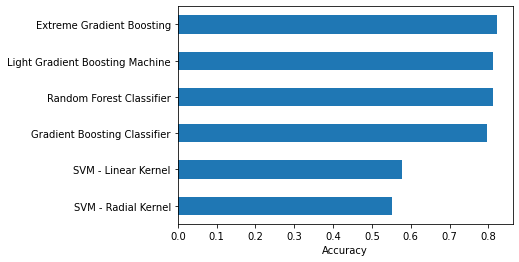

In [15]:
# For example, can also access experiment object to create a figure comparing accuracy for the various models
ax = exp1[8][6][1].set_index('Model')['Accuracy'].sort_values().plot.barh()
ax = ax.set(xlabel="Accuracy", ylabel="")

In [51]:
# Could also do a plot for all metrics if desired (not run)
# fig = exp1[8][6][1].set_index('Model').sort_values(by='Accuracy').T.plot.barh()
# fig.set_xlabel("Performance")
# fig.set_ylabel("")
# fig.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

In [16]:
# lets look at our candidate best model
candidate_model = 'xgboost'
selected_model = create_model(candidate_model, fold=num_folds)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8500,0.9798,0.7778,0.8750,0.8235,0.6939
1,0.7500,0.8788,0.7778,0.7000,0.7368,0.5000
2,0.8500,0.9495,0.7778,0.8750,0.8235,0.6939
3,0.8000,0.8586,0.5556,1.0000,0.7143,0.5789
4,0.8500,0.8636,0.6667,1.0000,0.8000,0.6875
5,0.8500,0.8485,0.8889,0.8000,0.8421,0.7000
6,0.8421,0.9222,0.7778,0.8750,0.8235,0.6816
7,0.8421,0.8111,0.7778,0.8750,0.8235,0.6816
8,0.8421,0.9222,0.8889,0.8000,0.8421,0.6851
9,0.7368,0.8778,1.0000,0.6429,0.7826,0.4865


In [17]:
# can check the defaults used
plot_model(selected_model, plot = 'parameter')

,Parameters
base_score,0.5
booster,gbtree
colsample_bylevel,1
colsample_bynode,1
colsample_bytree,1
gamma,0
learning_rate,0.1
max_delta_step,0
max_depth,3
min_child_weight,1


### Tuning

From the classification.py function we can see the parameter grid used via RandomizedSearchCV

```
param_grid = {'learning_rate': np.arange(0,1,0.01),
              'n_estimators':[10, 30, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 
              'subsample': [0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1],
              'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)], 
              'colsample_bytree': [0.5, 0.7, 0.9, 1],
              'min_child_weight': [1, 2, 3, 4]
}
```

In [18]:
# this is an example of using tune_model with defaults
tuned_model = tune_model(candidate_model, fold=num_folds)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.8000,0.8889,0.7778,0.7778,0.7778,0.5960
2,0.9000,0.9798,0.8889,0.8889,0.8889,0.7980
3,0.8000,0.8182,0.5556,1.0000,0.7143,0.5789
4,0.9000,0.8636,0.7778,1.0000,0.8750,0.7938
5,0.8000,0.9091,0.8889,0.7273,0.8000,0.6040
6,0.7895,0.8778,0.7778,0.7778,0.7778,0.5778
7,0.8421,0.8444,0.7778,0.8750,0.8235,0.6816
8,0.8947,0.9556,0.8889,0.8889,0.8889,0.7889
9,0.7895,0.9333,1.0000,0.6923,0.8182,0.5870


The tuning improved things slightly with all metrics improving ever so slightly. If you look under the hood a randomized grid-search with 10 iterations is being used. Of course, many more iterations could be used or even a different approach such as hyperopt. Additionaly, at this stage if we were interested in using the predicted probability we could also do some post-processing calibration. PyCaret has a great calibrate_model() function for this. For now we will put this aside. Typically I prefer non-parametric calibration (istonic to sigmoid), however, isotonic can be prone to overfit unless you have a large sample size, which we do not here.

Note if we had wanted to perform calibration of the predcited probabilities from the tuned model we could have used:  
`calibrated_model = calibrate_model(tuned_model, fold=num_folds)`  
`plot_model(calibrated_model, plot='calibration')`

In [19]:
# we can also take a peak at the tuned model object - not too much change given the samll amount of randomized search
plot_model(tuned_model, plot = 'parameter')

,Parameters
base_score,0.5
booster,gbtree
colsample_bylevel,1
colsample_bynode,1
colsample_bytree,1
gamma,0
learning_rate,0.8
max_delta_step,0
max_depth,100
min_child_weight,4


In [21]:
# WARNING: these slot locations can change depending on what you have run after compare models and also the number of times
# but lest just select the bottom part of the above output
exp1[8][10][1].loc[['Mean', 'SD']]

,Accuracy,AUC,Recall,Prec.,F1,Kappa
Mean,0.8516,0.9071,0.8333,0.8628,0.8364,0.7006
SD,0.0666,0.0565,0.1242,0.1095,0.0757,0.1338


In [22]:
# output for initial training to compare to above
exp1[8][8][1].loc[['Mean', 'SD']]

,Accuracy,AUC,Recall,Prec.,F1,Kappa
Mean,0.8213,0.8912,0.7889,0.8443,0.8012,0.6389
SD,0.0415,0.0485,0.1160,0.1084,0.0417,0.0800


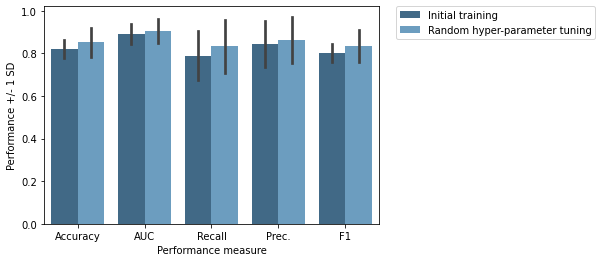

In [24]:
# create summary plot
initial_results = exp1[8][8][1].iloc[0:10].T.unstack().reset_index()
initial_results['stage'] = "Initial training"

tuned_results = exp1[8][10][1].iloc[0:10].T.unstack().reset_index()
tuned_results['stage'] = "Random hyper-parameter tuning"

training_summary = pd.concat([initial_results, tuned_results])

ax = sns.barplot(x="level_1", y=0, hue="stage", data=training_summary[~(training_summary.level_1.isin(['Kappa']))], ci="sd", palette="Blues_d")
ax.set(xlabel="Performance measure", ylabel = "Performance +/- 1 SD")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Evaluating the model
Briefly evaluate model provides an interactive cell output with many common useful plots and outputs - some of which will depend upon the model you are looking at. However, a great many are common to all models and it is always helpful to keep in mind what it is that is important to gleen from each output.  

Please note some options require additional processing when selected and so you may have to wait a bit depending upon how complex the task is that generates the plot. Currently, I don't believe results are cached so when you select another and go back it will require the same amount of wait time to produce again.

In [26]:
# using evaluate model provides a summary of many outputs that can be obtained individually via plot_model()
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

### Understanding what the model is telling us

As a summary of which features are important we can use a bar plot of the mean absolute value of the SHAP values for each feature.

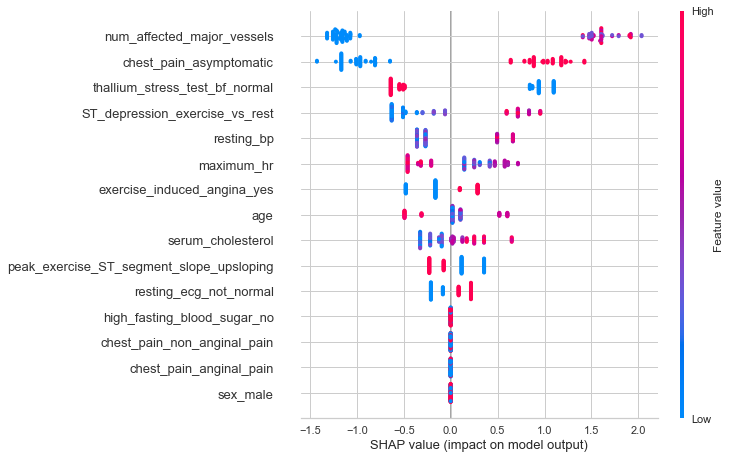

In [27]:
# understanding what is driving predictions using SHAP
interpret_model(tuned_model)

So it seems that the most important factors are the number of affected major vessels, asymptomatic chest pain and if your thallium stress test indicates normal blood flow. Now let's compare the contributions of features to the predicted risk score for heart disease for an example patient.

In [29]:
interpret_model(tuned_model, "reason", observation=94)

For this example patient factors such as no exercise induced angina, no affected major blood vessels and a normal blood flow result from the thallium stress test all contribute to lower the predcited risk score (-2.26, probability = 0.09) for heart disease compared to the base risk score (average model output) of -0.21 (probability = 0.45). This patient however is not as low risk as possible, as they have a couple of factors contributing to increase risk which are asymptomatic chest pain and non-normal ECG result.

In [30]:
interpret_model(tuned_model, "reason", observation=4)

For this patient the high degree of ST-T depression, their maximum heart rate, a blood flow defect according to the thallium stress test, asymptomatic chest pain and 2 affected major vessels all contribute to a high predicted risk score (4.97, probability = 0.99) for heart disease compared to the base risk score (average model output = -0.21, probability = 0.45).  Finally, lets look at some co-relationships between features and their impact on predictions.

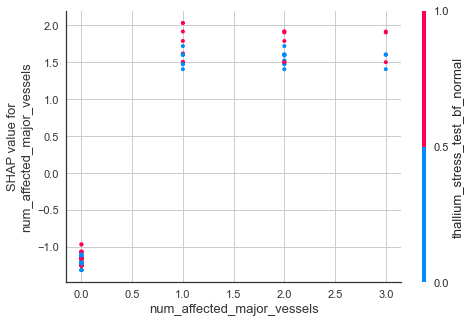

In [32]:
# Lets look at dependence plot as well
interpret_model(tuned_model, "correlation", feature="num_affected_major_vessels")

This plot shows what we might expect in that with affected vessels risk increases (higher SHAP value) and that this does not seem to modified too much by the result of normal on the Thallium stress test.

### Performance on the hold out set

In [33]:
# finally let's reassure ourselves that our model will generalize okay by checking performance in the hold-out set
pred_holdout = predict_model(tuned_model)
pred_holdout.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Extreme Gradient Boosting,0.757,0.8777,0.7347,0.7347,0.7347,0.5106


,age,resting_bp,serum_cholesterol,maximum_hr,ST_depression_exercise_vs_rest,num_affected_major_vessels,sex_male,chest_pain_anginal_pain,chest_pain_asymptomatic,chest_pain_non_anginal_pain,high_fasting_blood_sugar_no,resting_ecg_not_normal,exercise_induced_angina_yes,peak_exercise_ST_segment_slope_upsloping,thallium_stress_test_bf_normal,target,Label,Score
0,52.0,172.0,199.0,162.0,0.5,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,0.0636
1,69.0,140.0,239.0,151.0,1.8,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0,1,0.7378
2,51.0,94.0,227.0,154.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0,0,0.4937
3,43.0,150.0,247.0,171.0,1.5,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,0.3797
4,63.0,140.0,187.0,144.0,4.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1,1,0.9931


In [34]:
pred_holdout.Score.describe()

count    107.000000
mean       0.477703
std        0.379034
min        0.003600
25%        0.083950
50%        0.406700
75%        0.867400
max        0.997900
Name: Score, dtype: float64

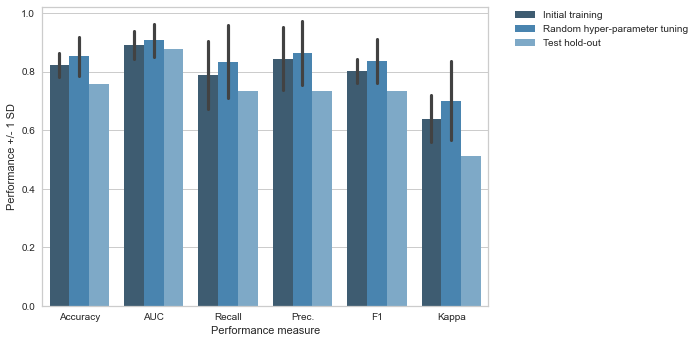

In [35]:
# lets look at the distribution of score values by outcome in the test set
# was not clear how to grab the hold-out performance as it is not returned from the object
test_summary = pd.DataFrame({'Accuracy': 0.757, 'AUC': 0.8777, 'Recall': 0.7347, 'Prec.': 0.7347, 'F1': 0.7347, 'Kappa': 0.5106}, index=[0]).T.unstack().reset_index()
test_summary['stage'] = 'Test hold-out'
full_summary = pd.concat([training_summary, test_summary])

ax = sns.barplot(x="level_1", y=0, hue="stage", data=full_summary, ci="sd", palette="Blues_d")
ax.set(xlabel="Performance measure", ylabel = "Performance +/- 1 SD")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# save this figure for article
plt.savefig("Fig_9_final_performance_summary.png", bbox_inches = "tight")

### Developing some thresholds for risk groups

Now the last task we will do, which is mainly to support the next step which is to use the deploy the developed model in Dash for use in the example context of a pilot, is to create some risk groups which will link to different sets of recommended actions. Of course this is a gross over-simplification especially in a medical context, and of course we are also not taking into account cost vs benefit here.

The general approach we follow it to create a response plot - the percentage of patients with heart disease in the test set by risk deciles according to the predcited probability of heart disease from the trained and tuned model. We will then identify some groups where thre is a clear high likelihood or low likelihood the patient will have heart disease. Based on the cut-points in predicted probability we will use these in our Dash application.

In [36]:
# Lets create some thresholds for use in the application we will develop
pred = pd.Series(tuned_model.predict_proba(exp1[3])[:,1])
pred.index = range(len(pred.index))
labels_all = pd.Series(exp1[5])
labels_all.index = range(len(labels_all.index))
full_pred = pd.concat([pred, labels_all], axis=1)
full_pred.columns = ['pred_pr', 'hd']

# lets bin into deciles and create data for a response plot to define some working thresholds for the pilot app
full_pred['deciles'], lims = pd.qcut(full_pred['pred_pr'], 10, labels=range(1,11), retbins=True)
agg_pred = full_pred.groupby('deciles').agg(p_correct = ('hd', 'mean'),
                                            sum_y = ('hd', 'sum'),
                                            count = ('hd', 'count')).reset_index().sort_values(by='deciles', ascending=False)

agg_pred['cumm_target'] = agg_pred['sum_y'].cumsum()
agg_pred['cumm_patients'] = agg_pred['count'].cumsum()
agg_pred['cumm_pct'] = agg_pred['cumm_target']/agg_pred['cumm_patients']
agg_pred['r_limit'] = lims[agg_pred['deciles']]

# apply mapping
agg_pred['risk_group'] = np.where(agg_pred['deciles'].isin([1,2,3,4]), 'Low risk',
                                 np.where(agg_pred['deciles'].isin([5,6,7]), 'Medium risk', 'High risk'))
agg_pred

,deciles,p_correct,sum_y,count,cumm_target,cumm_patients,cumm_pct,r_limit,risk_group
9,10,1.000000,11,11,11,11,1.000000,0.997943,High risk
8,9,1.000000,11,11,22,22,1.000000,0.981351,High risk
7,8,0.700000,7,10,29,32,0.906250,0.938164,High risk
6,7,0.500000,5,10,34,42,0.809524,0.795584,Medium risk
5,6,0.454545,5,11,39,53,0.735849,0.629052,Medium risk
4,5,0.363636,4,11,43,64,0.671875,0.406744,Medium risk
3,4,0.272727,3,11,46,75,0.613333,0.275686,Low risk
2,3,0.200000,2,10,48,85,0.564706,0.112766,Low risk
1,2,0.090909,1,11,49,96,0.510417,0.063981,Low risk
0,1,0.000000,0,11,49,107,0.457944,0.020513,Low risk


In [37]:
risk_group_stats = agg_pred.groupby('risk_group').agg(sum_y = ('sum_y', 'sum'), sum_n = ('count', 'sum')).reset_index()
risk_group_stats['percent'] = risk_group_stats['sum_y']/risk_group_stats['sum_n']
risk_group_stats.drop(['sum_y', 'sum_n'], axis=1)
risk_group_stats['risk_group_pct'] = risk_group_stats['risk_group'] + " (" + np.round(risk_group_stats['percent'],2).astype(str) + ")"
risk_group_stats

,risk_group,sum_y,sum_n,percent,risk_group_pct
0,High risk,29,32,0.906250,High risk (0.91)
1,Low risk,6,43,0.139535,Low risk (0.14)
2,Medium risk,14,32,0.437500,Medium risk (0.44)


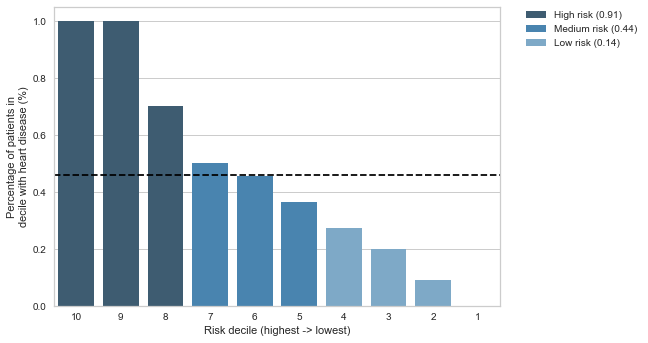

In [38]:
# create the plot
agg_pred1 = pd.merge(agg_pred, risk_group_stats, on='risk_group', how='left')
ax = sns.barplot(x='deciles', y='p_correct', data=agg_pred1, hue='risk_group_pct', dodge=False, order=agg_pred['deciles'], palette="Blues_d")
ax.axhline(agg_pred.sum_y.sum()/agg_pred['count'].sum(), ls='--', color='black')
ax = ax.set(xlabel="Risk decile (highest -> lowest)", ylabel = "Percentage of patients in\ndecile with heart disease (%)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

# save this figure for article
plt.savefig("Fig_10_risk_groups.png", bbox_inches = "tight")

### Saving the final model for future deployment

In a second article I will cover how we might make this developed model available to researchers or clinicians to use.

In [39]:
# finalize the model (i.e., re-train using all available data)
hd_model = finalize_model(tuned_model)

# save the final trained model for use in our application and also save the experiment as well
save_model(hd_model, 'heart_disease_predition_model_Jul2020')
save_experiment('heart_disease_experiment_Jul2020')

Transformation Pipeline and Model Succesfully Saved
Experiment Succesfully Saved


### ASIDE:  
### Replicating and extending SHAP plots by using the shap library directly with the PyCaret trained model

(Add some notes)

In [40]:
# Let's also see if we can do other SHAP value plots directly on the model object and choose whether we use prepared test or
# train data as above call for PyCaret appears to use test data
import shap
model = exp1[8][9][1]

# SHAP with test data (as is done via PyCaret)
X_test = exp1[3]
explainer_test = shap.TreeExplainer(model)
shap_values_test = explainer_test.shap_values(X_test)

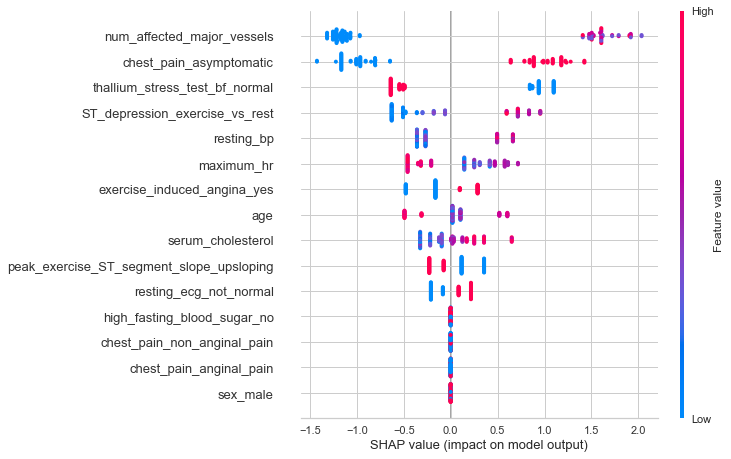

In [41]:
# reproduce summary plot from above via intepret model
shap.summary_plot(shap_values_test, X_test, show=False)
plt.savefig("Fig_7_SHAP_summary_plot.png", bbox_inches = "tight")

In [42]:
# can try to save using matplotlib=True, show=False, and plt.savefig() but doesn't look as nice so used SNIP tool to capture 
# individual forceplot above
# going through shap directly we can also opt to get probability scale as our xgboost using the binary:logistic objective function
shap.force_plot(explainer_test.expected_value, shap_values_test[94,:], feature_names=X_test.columns, link='logit')

In [43]:
shap.force_plot(explainer_test.expected_value, shap_values_test[4,:], feature_names=X_test.columns, link='logit')

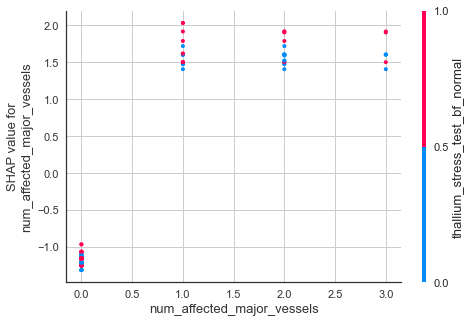

In [44]:
# produce first dependence plot from above
shap.dependence_plot("num_affected_major_vessels", shap_values_test, X_test)

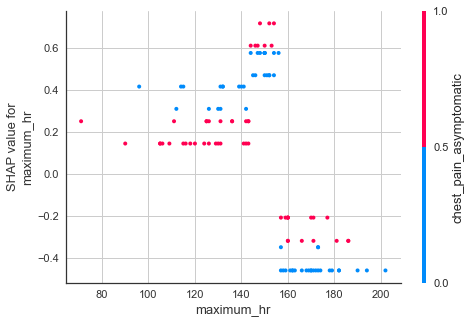

In [45]:
# with full control produce something that is maybe a bit easier to understand
shap.dependence_plot("maximum_hr", shap_values_test, X_test)

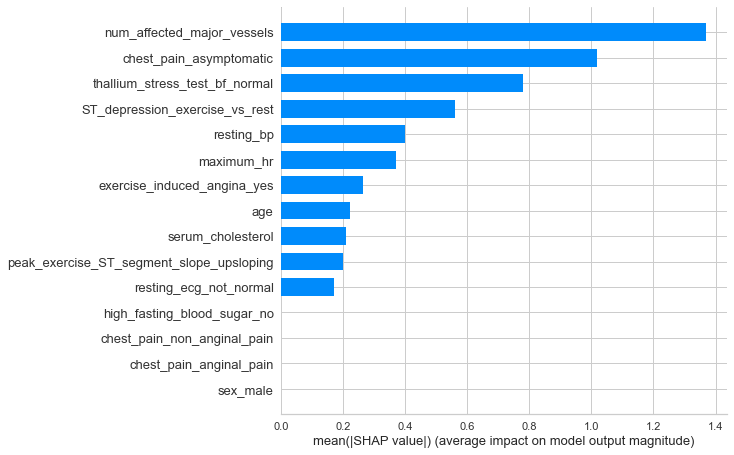

In [46]:
# alternative summary plot
shap.summary_plot(shap_values_test, X_test, plot_type="bar", show=False)
plt.savefig("SHAP_importance_for_dashboard.png", bbox_inches = "tight")

In [47]:
# combined force plot
shap.force_plot(explainer_test.expected_value, shap_values_test, X_test, link='logit')

Was going to do waterfall plot but this came along in version 0.33.0 and right now PyCaret 1.0.0 requires shap 0.32.1